In [1]:
%load_ext load_style
%load_style talk.css

# Trend and Anomaly Analyses of Long-term Tempro-Spatial Dataset

**Trend** and **anomaly** analyses are widely used in atmospheric and oceanographic research for detecting long term change.

An example is presented in this notebook of a numerical analysis of Sea Surface Temperature (SST) where the global change rate per decade has been calculated from 1982 to 2016. Moreover, its area-weighted global monthly SST anomaly time series is presented, too. In addition, all of calculating processes is list step by step.

* Data Source
> NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST) V2 is downloaded from https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html.
>
> Spatial Coverage:
> * 1.0 degree latitude x 1.0 degree longitude global grid (180x360).
> * 89.5N - 89.5S, 0.5E - 359.5E.
>
> Because oisst is an interpolated data, so it covers ocean and land. As a result, have to use land-ocean mask data at the same time, which is also available from the webstie.
>
> We select SST from 1982 to 2016.

## 1. Load basic libs

In [2]:
% matplotlib inline

from pylab import *
import numpy as np
import datetime 

from netCDF4 import netcdftime
from netCDF4 import Dataset as netcdf # netcdf4-python module
from netcdftime import utime

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.simplefilter('ignore')

## 2. Read SST data and pick variables

### 2.1 Read SST

In [3]:
ncset= netcdf(r'data/sst.mnmean.nc')
lons = ncset['lon'][:]  
lats = ncset['lat'][:]           
sst  = ncset['sst'][1:421,:,:]    # 1982-2016 to make it divisible by 12
nctime = ncset['time'][1:421]
t_unit = ncset['time'].units

try :
    t_cal =ncset['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

nt, nlat, nlon = sst.shape
ngrd = nlon*nlat

### 2.2 Parse time

In [4]:
utime = netcdftime.utime(t_unit, calendar = t_cal)
datevar = utime.num2date(nctime)
print(datevar.shape)

datevar[0:5]

(420L,)


array([datetime.datetime(1982, 1, 1, 0, 0),
       datetime.datetime(1982, 2, 1, 0, 0),
       datetime.datetime(1982, 3, 1, 0, 0),
       datetime.datetime(1982, 4, 1, 0, 0),
       datetime.datetime(1982, 5, 1, 0, 0)], dtype=object)

### 2.3 Read mask (1=ocen, 0=land)

In [5]:
lmfile = 'data\lsmask.nc'
lmset  = netcdf(lmfile)
lsmask = lmset['mask'][0,:,:]
lsmask = lsmask-1

num_repeats = nt
lsm = np.stack([lsmask]*num_repeats,axis=-1).transpose((2,0,1))
lsm.shape

(420L, 180L, 360L)

### 2.3 Mask out Land

In [6]:
sst = np.ma.masked_array(sst, mask=lsm)

## 3. Trend Analysis

### 3.1 Linear trend calculation

In [7]:
#import scipy.stats as stats
sst_grd  = sst.reshape((nt, ngrd), order='F') 
x        = np.linspace(1,nt,nt)#.reshape((nt,1))
sst_rate = np.empty((ngrd,1))
sst_rate[:,:] = np.nan

for i in range(ngrd): 
    y = sst_grd[:,i]   
    if(not np.ma.is_masked(y)):         
        z = np.polyfit(x, y, 1)
        sst_rate[i,0] = z[0]*120.0
        #slope, intercept, r_value, p_value, std_err = stats.linregress(x, sst_grd[:,i])
        #sst_rate[i,0] = slope*120.0     
    
sst_rate = sst_rate.reshape((nlat,nlon), order='F')

### 3.2 Visualize SST trend

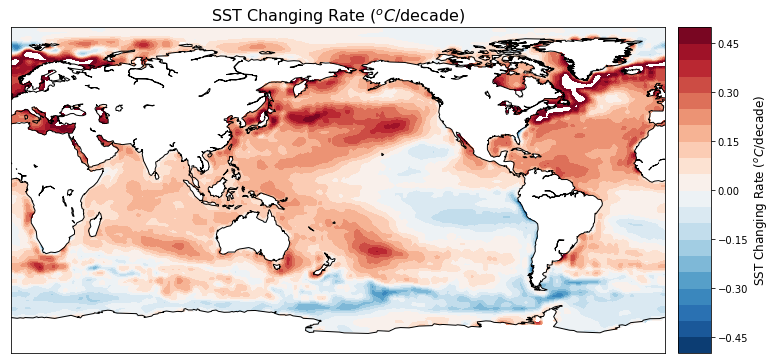

In [8]:
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-0.5, 0.5, 21)
cs = m.contourf(x, y, sst_rate.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()
#m.fillcontinents(color='#000000',lake_color='#99ffff')

cb = m.colorbar(cs)
cb.set_label('SST Changing Rate ($^oC$/decade)', fontsize=12)
plt.title('SST Changing Rate ($^oC$/decade)', fontsize=16)

## 4. Anomaly analysis

### 4.1 Convert sst data into nyear x12 x lat x lon

In [9]:
sst_grd_ym  = sst.reshape((12,nt/12, ngrd), order='F').transpose((1,0,2))
sst_grd_ym.shape

(35L, 12L, 64800L)

### 4.2 Calculate seasonal cycle

In [10]:
sst_grd_clm = np.mean(sst_grd_ym, axis=0)
sst_grd_clm.shape

(12L, 64800L)

### 4.3 Remove seasonal cycle

In [11]:
sst_grd_anom = (sst_grd_ym - sst_grd_clm).transpose((1,0,2)).reshape((nt, nlat, nlon), order='F')
sst_grd_anom.shape

(420L, 180L, 360L)

### 4.4 Calculate area-weights

#### 4.4.1 Make sure lat-lon grid direction

In [12]:
print(lats[0:12])
print(lons[0:12])

[ 89.5  88.5  87.5  86.5  85.5  84.5  83.5  82.5  81.5  80.5  79.5  78.5]
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5]


#### 4.4.2 Calculate area-weights with cos(lats)

In [13]:
lonx, latx = np.meshgrid(lons, lats)
weights = np.cos(latx * np.pi / 180.)

print(weights.shape)

(180L, 360L)


#### 4.4.3 Calculate valid grids total eareas for Global, NH and SH

In [14]:
sst_glb_avg = np.zeros(nt)
sst_nh_avg  = np.zeros(nt)
sst_sh_avg  = np.zeros(nt)

for it in np.arange(nt):
    sst_glb_avg[it] = np.ma.average(sst_grd_anom[it, :], weights=weights)
    sst_nh_avg[it]  = np.ma.average(sst_grd_anom[it,0:nlat/2,:],    weights=weights[0:nlat/2,:])
    sst_sh_avg[it]  = np.ma.average(sst_grd_anom[it,nlat/2:nlat,:], weights=weights[nlat/2:nlat,:])    

## 5. Visualize monthly SST anomaly time series

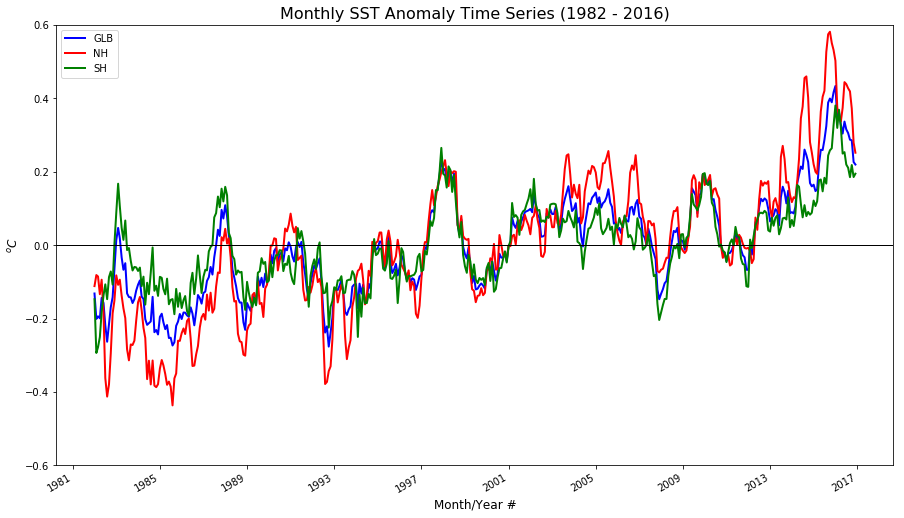

In [15]:
fig, ax = plt.subplots(1, 1 , figsize=(15,5))

ax.plot(datevar, sst_glb_avg, color='b', linewidth=2, label='GLB')
ax.plot(datevar, sst_nh_avg,  color='r', linewidth=2, label='NH')
ax.plot(datevar, sst_sh_avg,  color='g', linewidth=2, label='SH')

ax.axhline(0, linewidth=1, color='k')
ax.legend()
ax.set_title('Monthly SST Anomaly Time Series (1982 - 2016)', fontsize=16)
ax.set_xlabel('Month/Year #', fontsize=12)
ax.set_ylabel('$^oC$', fontsize=12)
ax.set_ylim(-0.6, 0.6)
fig.set_figheight(9)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y')

## References

http://unidata.github.io/netcdf4-python/

http://www.scipy.org/

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.

Matplotlib: A 2D Graphics Environment by J. D. Hunter In Computing in Science & Engineering, Vol. 9, No. 3. (2007), pp. 90-95

Reynolds, R.W., N.A. Rayner, T.M. Smith, D.C. Stokes, and W. Wang, 2002: An improved in situ and satellite SST analysis for climate. J. Climate, 15, 1609-1625.